# Реализация K-neariest neighbor на numpy

В статистике алгоритм k-nearest neighbors (k-NN) - это непараметрический метод контролируемого обучения. Он используется для решения задач классификации и регрессии. В обоих случаях на вход подаются k ближайших обучающих примеров в наборе данных. Выходные данные зависят от того, используется ли k-NN для классификации или регрессии:



*   в классификации k-NN выходным результатом является принадлежность к классу. Объект классифицируется путем множественного голосования его соседей, при этом объект относится к классу, наиболее распространенному среди k его ближайших соседей (k - целое положительное число, обычно небольшое). Если k = 1, то объект просто приписывается к классу единственного ближайшего соседа.
*   в задаче регрессии регрессии выходным результатом является значение свойства для объекта. Это значение является средним значением значений k ближайших соседей. Если k = 1, то выходное значение просто присваивается значению этого единственного ближайшего соседа.

Как для классификации, так и для регрессии полезным приемом может быть присвоение весов вкладам соседей таким образом, чтобы более близкие соседи вносили больший вклад в среднее значение, чем более удаленные. Например, распространенная схема взвешивания состоит в том, что каждому соседу присваивается вес 1/d, где d - расстояние до соседа.

**Алгоритм**

Обучающие примеры представляют собой векторы в многомерном пространстве признаков, каждый из которых имеет метку класса.

На этапе классификации k - константа (гиперпараметр), определяемая пользователем, и неразмеченный вектор данных классифицируется путем присвоения метки, которая наиболее часто встречается среди k ближайших к этой точке обучающих выборок.

В качестве метрики расстояния для непрерывных переменных обычно используется [евклидово расстояние](https://ru.wikipedia.org/wiki/%D0%95%D0%B2%D0%BA%D0%BB%D0%B8%D0%B4%D0%BE%D0%B2%D0%B0_%D0%BC%D0%B5%D1%82%D1%80%D0%B8%D0%BA%D0%B0). Для дискретных переменных, например, для классификации текстов, может использоваться другая метрика, например [расстояние Хэмминга](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%A5%D1%8D%D0%BC%D0%BC%D0%B8%D0%BD%D0%B3%D0%B0).

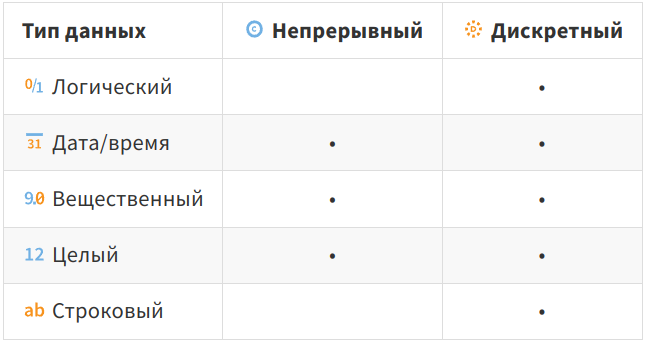

Недостаток базовой классификации "по большинству голосов" проявляется в случае дисбаланса распределения классов. То есть примеры более часто встречающегося класса имеют тенденцию доминировать в предсказании нового примера, поскольку они имеют тенденцию быть общими среди k ближайших соседей из-за их большого количества. Одним из способов преодоления этой проблемы является взвешивание классификации, учитывающее расстояние от тестовой точки до каждого из ее k ближайших соседей. Класс (или значение, в задачах регрессии) каждой из k ближайших точек умножается на вес, пропорциональный обратной величине расстояния от этой точки до тестовой точки.

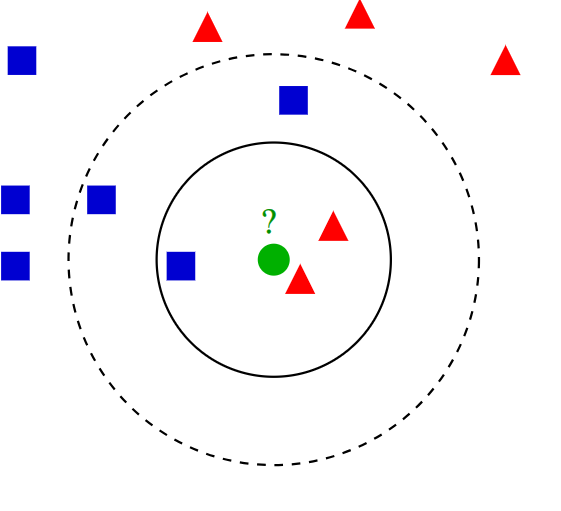

Пример классификации k-NN. Тестовый образец (зеленая точка) следует классифицировать либо по синим квадратам (класс №1), либо по красным треугольникам (класс №2). Если k = 3 (сплошной круг), он присваивается красным треугольникам, поскольку внутри внутреннего круга 2 треугольника и только 1 квадрат. Если k = 5 (пунктирный круг), он присваивается синим квадратам (3 квадрата против 2 треугольников внутри внешнего круга).

Источник: [wiki/K-nearest_neighbors_algorithm](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)

## Импорт данных

В этой рабочей тетради будем реализовывать k-nn:


*   для бинарной классификации (то есть, только двум классам)

Мы будем использовать цифры из датасета Street View House Numbers (SVHN, http://ufldl.stanford.edu/housenumbers/).

SVHN - это реальный набор данных изображений для разработки алгоритмов машинного обучения и распознавания объектов с минимальными требованиями к предварительной обработке и форматированию данных. По своим характеристикам он похож на MNIST (например, изображения маленьких обрезанных цифр), но содержит на порядок больше помеченных данных (более 600 тыс. изображений цифр) и основан на значительно более сложной, нерешенной проблеме реального мира (распознавание цифр и чисел на изображениях естественных сцен). SVHN получена на основе номеров домов на изображениях Google Street View.

In [1]:
# создаем папку и перемещаемся в нее
!mkdir data
!cd data
# загружаем обучающую и тестовую выборки
!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2023-08-28 12:06:17--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2023-08-28 12:06:17--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



После выполнения ячейки выше были скачаны два файла train_32x32.mat и test_32x32.mat

Файл представляет собой сохраненную рабочую область MATLAB, среды для программирования, численных расчетов и визуализации их результатов. Файл может содержать массив данных, переменные, функции или другой тип данных в двоичном (бинарном) формате.

Ниже напишем функции для формирования numpy массива из .mat файла и функцию разбиения массива на train_X, train_y, val_X, val_y подвыборпки.

> Лучше вынести весь код в отдельный файл и в дальнейшем импортировать из него необходимые функции.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import scipy.io as io
import os


def load_data_mat(filename, max_samples, seed=42):
    '''
    Loads numpy arrays from .mat file

    Returns:
    X, np array (num_samples, 32, 32, 3) - images
    y, np array of int (num_samples) - labels
    '''
    raw = io.loadmat(filename)
    # Функция scipy.io.loadmat вернет словарь из которого мы сможем
    # получить numpy массив признаков и numpy массив целевых меток
    X = raw['X']  # Массив [32, 32, 3, n_samples]
    y = raw['y']  # Массив [n_samples, 1]
    X = np.moveaxis(X, [3], [0])
    y = y.flatten()
    # Меняем лейбл нулевого класса на "0", по умолчанию был "10"
    y[y == 10] = 0

    np.random.seed(seed)
    samples = np.random.choice(np.arange(X.shape[0]),
                               max_samples,
                               replace=False)

    return X[samples].astype(np.float32), y[samples]


def load_svhn(folder, max_train, max_test):
    '''
    Загрузка набора данных SVHN из файла

    Аргументы:
    folder - путь к папке
    max_train - максимальное количество элементов для обучающей выборки
    max_test - максимальное количество элементов для тестовой выборки

    Возвращает:
    train_X, numpy массив (num_train, 32, 32, 3) - обучающие изображения
    train_y, numpy массив из цифр (num_train) - обучающие метки
    test_X, numpy массив (num_test, 32, 32, 3) - тестовые изображения
    test_y, numpy массив из цифр (num_test) - тестовые метки
    '''
    train_X, train_y = load_data_mat(os.path.join(folder, "train_32x32.mat"), max_train)
    test_X, test_y = load_data_mat(os.path.join(folder, "test_32x32.mat"), max_test)
    return train_X, train_y, test_X, test_y


def random_split_train_val(X, y, num_val, seed=42):
    '''
    Случайное разбиение набора данных на обучающий и тестовый

    Аргументы:
    X - numpy массив сэмплов
    y - numpy массив меток
    num_val - количество образцов для валидации
    seed - random seed

    Возвращает:
    train_X, numpy массив (num_train, 32, 32, 3) - массив с обучающими изображениями
    train_y, numpy массив из цифр (num_train) - массив с обучающими метками
    val_X, numpy массив (num_val, 32, 32, 3) - массив с тестовыми изображениями
    val_y, numpy массив из цифр (num_val) - массив с тестовыми метками
    '''
    np.random.seed(seed)

    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    train_indices = indices[:-num_val]
    train_X = X[train_indices]
    train_y = y[train_indices]

    val_indices = indices[-num_val:]
    val_X = X[val_indices]
    val_y = y[val_indices]

    return train_X, train_y, val_X, val_y

In [4]:
train_X, train_y, test_X, test_y = load_svhn("data", max_train=1000, max_test=100)

Убедимся, что функция отработала корректно и мы загрузили не все данные, а только часть, как и планировали (1000 на обучение и 100 на тест)

In [5]:
print(f"Количество элементов в обучающей выборке: {train_X.shape[0]}")
print(f"Количество элементов в тестовой выборке: {test_X.shape[0]}")

Количество элементов в обучающей выборке: 1000
Количество элементов в тестовой выборке: 100


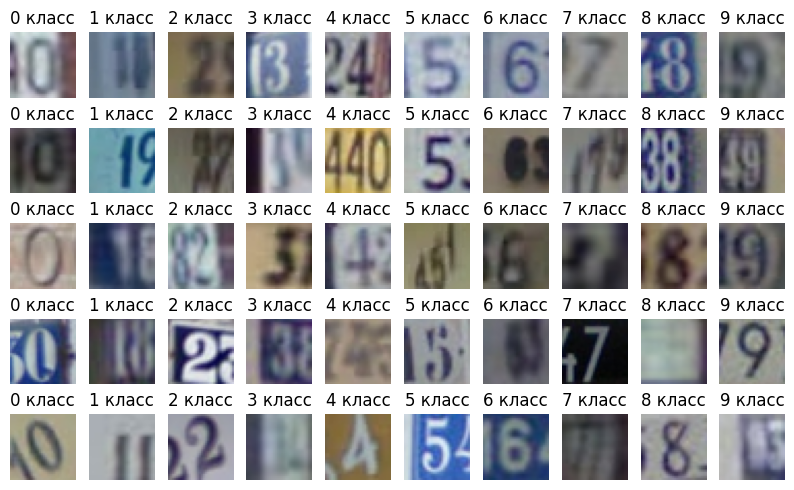

In [6]:
plt.figure(figsize=(10,6))
samples_per_class = 5  # количество строк элементов каждого класса
plot_index = 1
for example_index in range(samples_per_class):
    for class_index in range(10):
        plt.subplot(5, 10, plot_index)
        image = train_X[train_y == class_index][example_index]
        plt.title(f'{class_index} класс')
        plt.imshow(image.astype(np.uint8))
        plt.axis('off')
        plot_index += 1

## Бинарная классификация

В качестве задачи бинарной классификации мы натренируем модель, которая будет отличать цифру 0 от цифры 9.

In [7]:
# Для начала подготовим метки и исходные  данные

# Выбираем только 0-ой и 9-ый классы
binary_train_mask = (train_y == 0) | (train_y == 9)
binary_train_X = train_X[binary_train_mask]
binary_train_y = train_y[binary_train_mask] == 0

binary_test_mask = (test_y == 0) | (test_y == 9)
binary_test_X = test_X[binary_test_mask]
binary_test_y = test_y[binary_test_mask] == 0

После применения бинарной маски на обучающей выборке осталось 121 изображение из 1000

In [8]:
binary_train_X.shape

(121, 32, 32, 3)

In [11]:
# массив - одно изображение
binary_train_X[0]

array([[[216., 227., 231.],
        [209., 221., 223.],
        [197., 209., 210.],
        ...,
        [108.,  75.,  79.],
        [111.,  77.,  77.],
        [112.,  78.,  76.]],

       [[207., 218., 224.],
        [203., 214., 219.],
        [197., 209., 210.],
        ...,
        [110.,  79.,  80.],
        [111.,  79.,  78.],
        [112.,  79.,  77.]],

       [[189., 199., 208.],
        [191., 201., 209.],
        [195., 206., 210.],
        ...,
        [114.,  84.,  85.],
        [113.,  82.,  81.],
        [112.,  81.,  79.]],

       ...,

       [[155., 164., 166.],
        [150., 158., 161.],
        [145., 151., 154.],
        ...,
        [117.,  87.,  91.],
        [123.,  90.,  92.],
        [126.,  91.,  92.]],

       [[162., 173., 174.],
        [160., 170., 172.],
        [158., 167., 169.],
        ...,
        [112.,  80.,  85.],
        [117.,  83.,  86.],
        [120.,  84.,  87.]],

       [[166., 178., 178.],
        [165., 177., 177.],
        [164., 1

In [12]:
# Преобразуем в одномерный массив [num_samples, 32*32*3]
binary_train_X = binary_train_X.reshape(binary_train_X.shape[0], -1)
binary_test_X = binary_test_X.reshape(binary_test_X.shape[0], -1)

In [13]:
print('shape:', binary_train_X.shape)
binary_train_X

shape: (121, 3072)


array([[216., 227., 231., ..., 116.,  79.,  83.],
       [ 98.,  86., 101., ...,  51.,  42.,  47.],
       [192., 175., 165., ..., 175., 166., 151.],
       ...,
       [ 42.,  50.,  86., ...,  54.,  71.,  84.],
       [137., 139., 128., ..., 138., 143., 139.],
       [142., 178., 214., ..., 132., 150., 170.]], dtype=float32)

### Пишем класс нашего K-nn

Лучше писать код класса в отдельном файле, а затем ипортировать его, но чтобы отразить всю информацию в рамках одного ноутбука я буду писать код в этой рабочей тетради.

Для простоты реализации мы будем использовать в качестве расстояния меру L1 (ее еще называют [Manhattan distance](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D1%81%D0%BA%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B0%D0%BB%D0%BE%D0%B2))

In [14]:
# knn.py
import numpy as np
from scipy import stats


class KNN:
    """
    K-neariest-neighbor классификатор с L1 нормой
    """
    def __init__(self, k=1):
        self.k = k

    def fit(self, X, y):
        self.train_X = X
        self.train_y = y

    def predict(self, X, num_loops=0):
        '''
        Использует модель KNN для предсказания классов для предоставленных
        образцов данных

        Аргументы:
        X, numpy массив (num_samples, num_features) - выборки для прогона через
            модель
        num_loops, int - какую реализацию использовать

        Возвращает:
        predictions, numpy массив из чисел (num_samples) - предсказание класса
            для каждого образца

        '''
        if num_loops == 0:
            dists = self.compute_distances_no_loops(X)
        elif num_loops == 1:
            dists = self.compute_distances_one_loop(X)
        else:
            dists = self.compute_distances_two_loops(X)

        if self.train_y.dtype == np.bool:
            return self.predict_labels_binary(dists)


    def compute_distances_two_loops(self, X):
        '''
        Вычисляет расстояние L1 от каждого образца X до каждого обучающего
            образца
        Используется простейшая реализация с 2 циклами Python

        Arguments:
        X, numpy массив (num_test_samples, num_features) - выборки для
            вычислений

        Возвращает:
        dists, numpy массив (num_test_samples, num_train_samples) - массив с
            расстояниями между каждой тестовым сэмплом и каждым обучающим сэмплом
        '''
        num_train = self.train_X.shape[0]
        num_test = X.shape[0]
        dists = np.zeros((num_test, num_train), np.float32)
        for i_test in range(num_test):
            for i_train in range(num_train):
                dists[i_test, i_train] = np.sum(abs(X[i_test, :] - self.train_X[i_train, :]))
        return dists

    def compute_distances_one_loop(self, X):
        '''
        Вычисляет расстояние L1 от каждого образца X до каждого обучающего
            образца
        Векторизует некоторые вычисления, поэтому используется только один цикл

        Аргументы:
        X, numpy массив (num_test_samples, num_features) - выборки для
            вычислений

        Возвращает:
        dists, numpy массив (num_test_samples, num_train_samples) - массив с
            расстояниями между каждой тестовым сэмплом и каждым обучающим сэмплом
        '''
        num_train = self.train_X.shape[0]
        num_test = X.shape[0]
        dists = np.zeros((num_test, num_train), np.float32)
        for i_test in range(num_test):
            dists[i_test, :] = np.sum(np.abs((self.train_X - X[i_test, :])), axis=1)
        return dists

    def compute_distances_no_loops(self, X):
        '''
        Вычисляет расстояние L1 от каждого образца X до каждого обучающего
            образца полностью векторизует вычисления с помощью numpy

        Аргументы:
        X, numpy массив (num_test_samples, num_features) - выборки для
            вычислений

        Возвращает:
        dists, numpy массив (num_test_samples, num_train_samples) - массив с
            расстояниями между каждой тестовым сэмплом и каждым обучающим сэмплом
        '''
        num_train = self.train_X.shape[0]
        num_test = X.shape[0]
        # Использование float32 для экономии памяти - по умолчанию используется
        # float64
        dists = np.zeros((num_test, num_train), np.float32)
        dists = np.sum(np.abs((X[:, np.newaxis] - self.train_X)), axis=2)
        return dists

    def predict_labels_binary(self, dists):
        '''
        Возвращает предсказания модели для случая бинарной классификации

        Аргументы:
        dists, numpy массив (num_test_samples, num_train_samples) - массив с
            расстояниями между каждой тестовым сэмплом и каждым обучающим сэмплом

        Возвращает:
        pred, numpy массив bool (num_test_samples) - бинарные предсказания
           для каждой тестового сэмпла
        '''
        num_test = dists.shape[0]
        pred = np.zeros(num_test, np.bool)
        for i in range(num_test):
            pred[i] = stats.mode(self.train_y[dists[i].argsort()][:self.k]).mode
        return pred

После того как наш класс написан, можно проверить скорость работы разных его реализаций:

1.   С двумя циклами `compute_distances_two_loops` (без векторизации из numpy)
2.   С одним циклом `compute_distances_one_loop` (с частичной векторизацией numpy)
3.   Без циклов `compute_distances_no_loops`(полностью векторизует вычисления с помощью numpy)

In [89]:
# Создаем классификатор и вызываем .fit() для тренировки модели
# KNN просто запоминает все данные
knn_classifier = KNN(k=1)
knn_classifier.fit(binary_train_X, binary_train_y)

Реализуем методы:

*   compute_distances_two_loops
*   compute_distances_one_loop
*   compute_distances_no_loops
класса KNN

Ниже можем проверить скорость работы каждого из них:

In [90]:
dists = knn_classifier.compute_distances_two_loops(binary_test_X)
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))

In [91]:
dists = knn_classifier.compute_distances_one_loop(binary_test_X)
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))

In [92]:
dists = knn_classifier.compute_distances_no_loops(binary_test_X)
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))

In [20]:
%%time
knn_classifier.compute_distances_two_loops(binary_test_X)

CPU times: user 24.7 ms, sys: 0 ns, total: 24.7 ms
Wall time: 24.8 ms


array([[179952., 386833., 135249., ..., 333468., 226102., 128616.],
       [162721., 177636., 136718., ..., 153065.,  63917., 196235.],
       [196969., 123306., 217824., ...,  69135., 159849., 292455.],
       ...,
       [139992., 178517., 105113., ..., 134708.,  82620., 192338.],
       [205567., 118504., 219610., ..., 101701., 187631., 292051.],
       [160404., 127059., 155853., ...,  97218.,  74362., 229166.]],
      dtype=float32)

In [21]:
%%time
knn_classifier.compute_distances_one_loop(binary_test_X)

CPU times: user 9.02 ms, sys: 0 ns, total: 9.02 ms
Wall time: 8.93 ms


array([[179952., 386833., 135249., ..., 333468., 226102., 128616.],
       [162721., 177636., 136718., ..., 153065.,  63917., 196235.],
       [196969., 123306., 217824., ...,  69135., 159849., 292455.],
       ...,
       [139992., 178517., 105113., ..., 134708.,  82620., 192338.],
       [205567., 118504., 219610., ..., 101701., 187631., 292051.],
       [160404., 127059., 155853., ...,  97218.,  74362., 229166.]],
      dtype=float32)

In [22]:
%%time
knn_classifier.compute_distances_no_loops(binary_test_X)

CPU times: user 11.8 ms, sys: 9.98 ms, total: 21.7 ms
Wall time: 21.8 ms


array([[179952., 386833., 135249., ..., 333468., 226102., 128616.],
       [162721., 177636., 136718., ..., 153065.,  63917., 196235.],
       [196969., 123306., 217824., ...,  69135., 159849., 292455.],
       ...,
       [139992., 178517., 105113., ..., 134708.,  82620., 192338.],
       [205567., 118504., 219610., ..., 101701., 187631., 292051.],
       [160404., 127059., 155853., ...,  97218.,  74362., 229166.]],
      dtype=float32)

In [ ]:
prediction = knn_classifier.predict(binary_test_X)


In [95]:
prediction

array([ True,  True, False,  True,  True,  True, False,  True,  True,
       False,  True,  True,  True,  True, False, False])

Далее нам нужно оценить насколько верные предсказания выдает наш алгоритм. Для этого напишем функцию для оценки работы алогоритма бинарной классификации.

> Как и с другим кодом наших функций и класса лучше вынести код ячейки ниже в отдельный файл, а затем импортировать его в рабочую тетрадь

In [96]:
def binary_classification_metrics(prediction, ground_truth):
    '''
    Вычисление метрик для бинарной классификации

    Аргументы:
    prediction, numpy массив bool (num_samples) - предсказания модели
    ground_truth, numpy массив bool (num_samples) - верные ответы

    Возвращает:
    precision, recall, f1, accuracy - метрики (точность, полнота,
        среднее гармоническое, доля верных ответов )
    '''
    precision = 0
    recall = 0
    accuracy = 0
    f1 = 0

    # https://en.wikipedia.org/wiki/Precision_and_recall
    # https://en.wikipedia.org/wiki/F1_score
    tp = 0  # TruePositive
    tn = 0  # TreuNegative
    fp = 0  # FalsePositive
    fn = 0  # FalseNegative

    for prediction, ground_truth in zip(prediction, ground_truth):
        if prediction == ground_truth and ground_truth == True:
            tp += 1
        if prediction == ground_truth and ground_truth == False:
            tn += 1
        if prediction != ground_truth and ground_truth == True:
            fn += 1
        if prediction != ground_truth and ground_truth == False:
            fp += 1

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    accuracy = (tp + tn) / (tp + tn + fn + fp)
    f1 = 2 * (precision * recall / (precision + recall))
    return precision, recall, f1, accuracy

In [97]:
precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("KNN with k = %s" % knn_classifier.k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1))

KNN with k = 1
Accuracy: 0.56, Precision: 0.73, Recall: 0.67, F1: 0.70


In [ ]:
# Создадим экземпляр класса KNN с k=3 и посчитаем метрики
knn_classifier_3 = KNN(k=3)
knn_classifier_3.fit(binary_train_X, binary_train_y)
prediction = knn_classifier_3.predict(binary_test_X)

In [99]:
precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("KNN with k = %s" % knn_classifier_3.k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1))

KNN with k = 3
Accuracy: 0.56, Precision: 0.73, Recall: 0.67, F1: 0.70


In [ ]:
# Создадим экземпляр класса KNN с k=10 и посчитаем метрики
knn_classifier_10 = KNN(k=10)
knn_classifier_10.fit(binary_train_X, binary_train_y)
prediction = knn_classifier_10.predict(binary_test_X)

In [101]:
precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("KNN with k = %s" % knn_classifier_10.k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1))

KNN with k = 10
Accuracy: 0.50, Precision: 0.67, Recall: 0.67, F1: 0.67


Для подбора наилучшего гиперпараметра k необходимо воспользоваться кросс-валидацией, но это выходит за рамки данной рабочей тетради. Ознакомиться что такое k-fold cross-validation (https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation) можно по этой ссылке.

## Визуализируем ошибки модели

В тестовую выборку попали всего 16 примеров

In [123]:
# индексы картинок с 0 или 9 классом
indices = np.where((test_y == 0) | (test_y == 9))
indices

(array([ 3,  6, 12, 13, 14, 18, 22, 26, 38, 46, 55, 65, 66, 76, 90, 97]),)

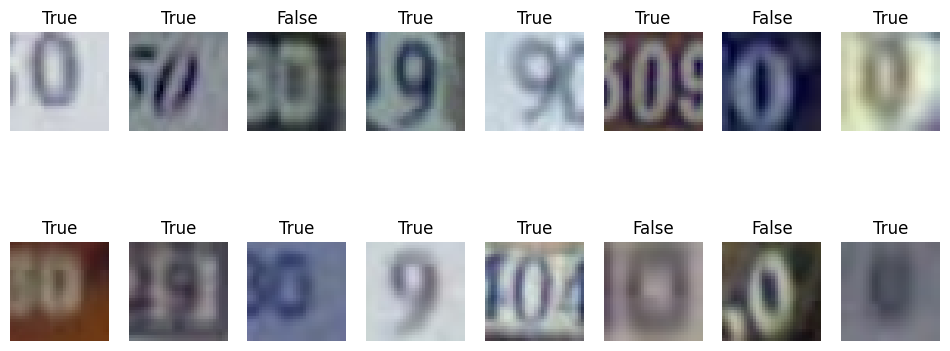

In [126]:
fig, axs = plt.subplots(2, 8, figsize=(12,5))
plt.axis('off')

img_index = 0
for row in range(2):
    for column in range(8):
        image = test_X[indices][img_index]
        axs[row, column].imshow(image.astype(np.uint8))
        axs[row, column].set_title(prediction[img_index])
        axs[row, column].axis('off')
        img_index += 1
        plot_index += 1

Итого 12 из 16 изображений были правильно классифицированы